In [ ]:
import kagglehub
dataset_path = kagglehub.dataset_download("indk214/brain-tumor-dataset-segmentation-and-classification")

# Import libraries
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_sauvola
from skimage.morphology import remove_small_objects



100%|██████████| 723M/723M [00:09<00:00, 76.3MB/s]

Extracting files...


In [ ]:
# Collect image-mask pairs
image_paths = []
mask_paths = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".png") and not file.endswith("_mask.png"):
            img_path = os.path.join(root, file)
            mask_path = img_path.replace(".png", "_mask.png")
            if os.path.exists(mask_path):
                image_paths.append(img_path)
                mask_paths.append(mask_path)

print("Total image-mask pairs:", len(image_paths))

Total image-mask pairs: 2192


In [ ]:
# Set image size
IMG_SIZE = 256

# Define metrics
def dice(y_true, y_pred):
    inter = np.sum(y_true * y_pred)
    return 2 * inter / (np.sum(y_true) + np.sum(y_pred) + 1e-8)

def jaccard(y_true, y_pred):
    inter = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - inter
    return inter / (union + 1e-8)



Window=7, k=0.1 → Dice=0.0370
Window=11, k=0.15 → Dice=0.0372
Window=21, k=0.2 → Dice=0.0390
Window=31, k=0.25 → Dice=0.0419
Window=41, k=0.35 → Dice=0.0447
Window=61, k=0.45 → Dice=0.0505
Window=81, k=0.55 → Dice=0.0577

Best Sauvola Parameters: (81, 0.55)
Best Dice: 0.0577


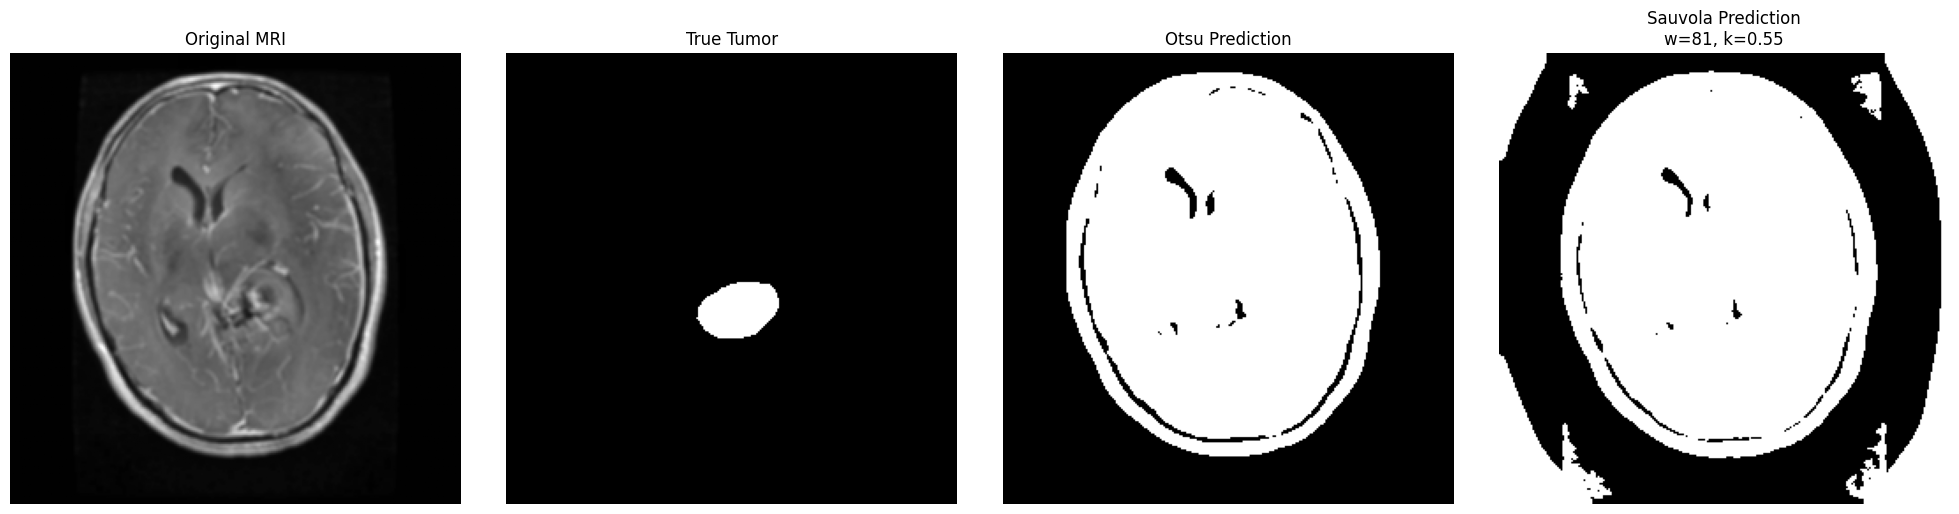

In [30]:
# CONFIG
IMG_SIZE = 256
SUBSET = 400

param_sets = [(7,0.1),(11,0.15),(21,0.2),(31,0.25),(41,0.35),(61,0.45),(81,0.55)]


# METRIC
def dice(gt, pred):
    intersection = np.sum(gt * pred)
    return (2.0 * intersection) / (np.sum(gt) + np.sum(pred) + 1e-6)

# PREPROCESS
def preprocess(img, mask):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    mask = (mask > 127).astype(np.uint8)
    img = cv2.GaussianBlur(img, (5,5), 0)
    return img, mask


# OTSU
def apply_otsu(image):
    t = threshold_otsu(image)
    return (image > t).astype(np.uint8)


# SAUVOLA
def apply_sauvola(image, window, k):
    t = threshold_sauvola(image, window_size=window, k=k)
    pred = (image > t).astype(np.uint8)
    pred = remove_small_objects(pred.astype(bool), min_size=100)
    return pred.astype(np.uint8)


# LOAD ALL DATA
all_images = []
all_masks = []

for img_path, mask_path in zip(image_paths, mask_paths):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img, mask = preprocess(img, mask)
    all_images.append(img)
    all_masks.append(mask)


# SAUVOLA HYPERPARAM SEARCH
best_dice = 0
best_params = None

for window, k in param_sets:
    scores = []

    for img, mask in zip(all_images[:SUBSET], all_masks[:SUBSET]):
        pred = apply_sauvola(img, window, k)
        scores.append(dice(mask, pred))

    mean_d = np.mean(scores)
    print(f"Window={window}, k={k} → Dice={mean_d:.4f}")

    if mean_d > best_dice:
        best_dice = mean_d
        best_params = (window, k)

print("\nBest Sauvola Parameters:", best_params)
print("Best Dice:", round(best_dice,4))


# TEST IMAGE VISUALIZATION
test_img = all_images[0]
test_mask = all_masks[0]

otsu_result = apply_otsu(test_img)

sauvola_result = apply_sauvola(test_img, best_params[0], best_params[1])


# SHOW COMPARISON

fig, axes = plt.subplots(1,4, figsize=(20,5))

axes[0].imshow(test_img, cmap='gray')
axes[0].set_title("Original MRI")
axes[0].axis("off")

axes[1].imshow(test_mask, cmap='gray')
axes[1].set_title("True Tumor")
axes[1].axis("off")

axes[2].imshow(otsu_result, cmap='gray')
axes[2].set_title("Otsu Prediction")
axes[2].axis("off")

axes[3].imshow(sauvola_result, cmap='gray')
axes[3].set_title(f"Sauvola Prediction\nw={best_params[0]}, k={best_params[1]}")
axes[3].axis("off")

plt.tight_layout()
plt.show()



In [35]:
from tqdm import tqdm

dice_otsu = []
dice_sauvola = []
jacc_otsu = []
jacc_sauvola = []

window, k = best_params  # best Sauvola params

for img, mask in tqdm(zip(all_images, all_masks), total=len(all_images)):

    # Otsu
    otsu_mask = apply_otsu(img)
    otsu_mask = remove_small_objects(otsu_mask.astype(bool), min_size=100).astype(np.uint8)

    # Sauvola (best)
    sauvola_mask = apply_sauvola(img, window, k)

    # Metrics
    dice_otsu.append(dice(mask, otsu_mask))
    dice_sauvola.append(dice(mask, sauvola_mask))

    jacc_otsu.append(jaccard(mask, otsu_mask))
    jacc_sauvola.append(jaccard(mask, sauvola_mask))


# FINAL SCORES
print("Otsu Dice:", np.mean(dice_otsu))
print("Sauvola Dice:", np.mean(dice_sauvola))

print("Otsu Jaccard:", np.mean(jacc_otsu))
print("Sauvola Jaccard:", np.mean(jacc_sauvola))


100%|██████████| 2192/2192 [00:21<00:00, 104.10it/s]

Otsu Dice: 0.06195858233517053
Sauvola Dice: 0.046797551476914445
Otsu Jaccard: 0.03272572440819738
Sauvola Jaccard: 0.02433798880016966



Otsu Mean Dice: 0.06195858233517053
Otsu Mean Jaccard: 0.03272572440819738
Sauvola Mean Dice: 0.046797551476914445
Sauvola Mean Jaccard: 0.02433798880016966


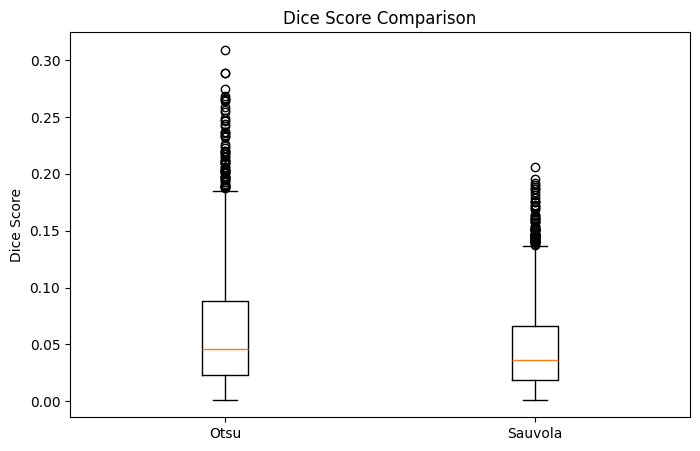

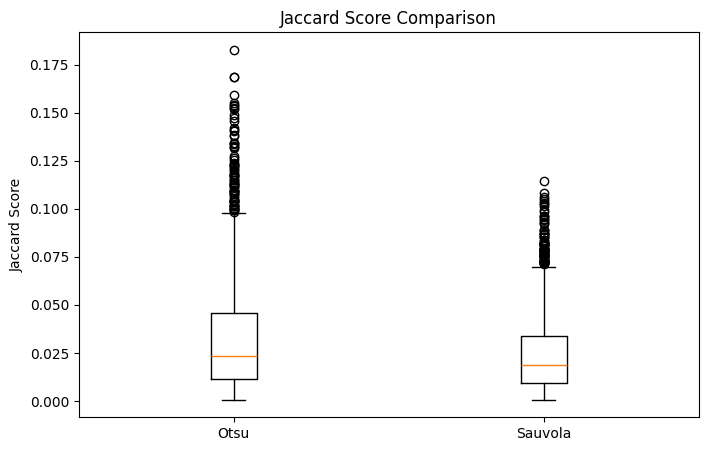

In [36]:

print("\nOtsu Mean Dice:", np.mean(dice_otsu))
print("Otsu Mean Jaccard:", np.mean(jacc_otsu))
print("Sauvola Mean Dice:", np.mean(dice_sauvola))
print("Sauvola Mean Jaccard:", np.mean(jacc_sauvola))

# Plot comparison
plt.figure(figsize=(8,5))
plt.boxplot([dice_otsu, dice_sauvola], tick_labels=["Otsu","Sauvola"])
plt.ylabel("Dice Score")
plt.title("Dice Score Comparison")
plt.show()

# Jaccard plot
plt.figure(figsize=(8,5))
plt.boxplot([jacc_otsu, jacc_sauvola], tick_labels=["Otsu","Sauvola"])
plt.ylabel("Jaccard Score")
plt.title("Jaccard Score Comparison")
plt.show()

# Result and conclusion

Both methods are actually failing badly - they're segmenting almost the entire brain region instead of just the small tumor shown in the ground truth. The Dice scores of 0.062 (Otsu) and 0.047 (Sauvola) are extremely low, indicating only 6.2% and 4.7% overlap with the true tumor respectively.

What I am thinking is that simple thresholding cannot effectively isolate tumors when they share similar intensity ranges with surrounding healthy brain tissue.